In [224]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import os
verbose_state = True

In [2]:
def print_c(print_content, verbose = verbose_state):
    
    if verbose == True:
        print(print_content)

In [3]:
print_c("Read pickle data")

f = open('./Data/all_data.pkl', 'rb')
_ = pickle.load(f)
_ = pickle.load(f)
process_data = pd.DataFrame(pickle.load(f))

print_c("Finish read pickle data")
print_c("Process data")

Read pickle data
Finish read pickle data
Process data


In [124]:
#select date
mask = (process_data.columns >= '20130102') & (process_data.columns < '20140302')
select_date = process_data.iloc[:,mask]

#drop NA
select_date = select_date.dropna()

for c in select_date.columns:    
    for idx in select_date[c].index:
        select_date[c].loc[idx] = select_date[c].loc[idx].drop(['ID', 'Date','name','trade']).tolist()
        
#make a stck_df to np_array 
stock_1101 = select_date.loc['1101']
stock_1101_np = np.vstack(np.array(stock_1101))

'''
#make multiple stck_df to np_array        
stocks = ['1101','1102']
stock_1101_02 = select_date.loc[stocks]
stock_1101_02_np = np.hstack(np.array(stock_1101_02))
stock_1101_02_np = np.vstack(np.array(stock_1101_02_np))
stock_1101_02_np_r = np.split(stock_1101_02_np, len(stocks))
stock_1101_02_np_r = np.dstack(stock_1101_02_np_r)
'''

In [125]:
#Check process is correct
print_c("single stock == multiple_stock: {}".format(np.equal(stock_1101_np, stock_1101_02_np_r[:,:,0]).all()))

single stock == multiple_stock: True


In [126]:
#Prepare for rnn
print_c("Start build RNN model")

import tensorflow as tf
import random

Start build RNN model


In [200]:
#Single stock

data = stock_1101_np
train_step = 12
test_step = 5
all_step = train_step + test_step
data_size = 50
n_inputs = data.shape[-1]
n_hidden_units = 10
n_output = 3
batch_size = 16


train_portion = int(0.8*len(data))
train, val = np.split(data, [train_portion])

def gen_train_val_set(data, total_time_step):

    data_set = np.zeros((len(data)-total_time_step, total_time_step, data.shape[-1]))

    for i in range(len(data)-total_time_step):

        tmp = data[i:i+total_time_step,:]
        data_set[i] = tmp
        
    return data_set

total_time_step = train_step + test_step
train_set = gen_train_val_set(train, total_time_step)
test_set = gen_train_val_set(val, total_time_step)




In [204]:
print(np.shape(train_set))
print(np.shape(test_set))

(207, 17, 4)
(40, 17, 4)


In [147]:
reuse = True

def default_init(seed):
    # replica of tf.glorot_uniform_initializer(seed=seed)
    return tf.contrib.layers.variance_scaling_initializer(factor=1.0,
                                               mode="FAN_AVG",
                                               uniform=True,
                                               seed=seed)

with tf.variable_scope('cell') as scope:
    # Define weights  
    if reuse: scope.reuse_variables()
    weights = {  
        # (28, 128)  
        'in': tf.get_variable("Win", [data.shape[-1], n_hidden_units], initializer = tf.zeros_initializer()),
        # (128, 10)  
        'out': tf.get_variable("Wout", [n_hidden_units, n_output], initializer = tf.zeros_initializer())
    }  

  
    biases = {  
        # (128, )  
        'in': tf.get_variable('b_in', [n_hidden_units, ], initializer = tf.constant_initializer(0.1)),  
        # (10, )  
        'out': tf.get_variable('b_out', [n_output, ],initializer = tf.constant_initializer(0.1))  
    }  
    

def encoder(X, weights, biases):  
    # hidden layer for input to cell  
    ########################################  
  
    # transpose the inputs shape from  
    # X ==> (128 batch * 28 steps, 28 inputs)  
    X = tf.reshape(X, [-1, n_inputs])  
  
    # into hidden  
    # X_in = (batch * time_steps, n_hidden_units)  
    X_in = tf.matmul(X, weights['in']) + biases['in']  
    # X_in ==> (batch, 28 time_steps, n_hidden_units)  
    X_in = tf.reshape(X_in, [-1, train_step, n_hidden_units]) 
    
    with tf.variable_scope('encoder') as scope:
        if reuse: scope.reuse_variables()
        cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden_units)
        init_state = cell.zero_state(batch_size, dtype=tf.float32) 
        outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, initial_state=init_state, time_major=False,scope='cell')  
    
    return outputs, final_state

def decoder(previous_y, state):
    
    predict_days = 5
    with tf.variable_scope('decoder') as scope:
            if reuse: scope.reuse_variables()
            cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden_units)
    
    def cond_fn(time, prev_output, prev_state, array_targets: tf.TensorArray, array_outputs: tf.TensorArray):
        return time < predict_days
    
    def project_fn(tensor):
        with tf.variable_scope('decoder_output_proj') as scope:
            if reuse: scope.reuse_variables()
            d_layer = tf.layers.dense(tensor, 1, name='decoder_output_proj', kernel_initializer=default_init(0))
        return d_layer

    def loop_fn(time, prev_output, prev_state, array_targets: tf.TensorArray, array_outputs: tf.TensorArray):
        
        next_input = prev_output
        
        with tf.variable_scope('decoder') as scope:
            if reuse: scope.reuse_variables()
            output, state = cell(next_input, prev_state)
            projected_output = project_fn(output)
            #projected_output = output
        
        array_outputs = array_outputs.write(time, output)
        array_targets = array_targets.write(time, projected_output)
        
        return time + 1, projected_output, state, array_targets, array_outputs
    
    loop_init = [tf.constant(0, dtype=tf.int32), #time
                     project_fn(previous_y), 
                     state,
                     tf.TensorArray(dtype=tf.float32, size=predict_days),
                     tf.TensorArray(dtype=tf.float32, size=predict_days) ]
        
    _, _, _, targets_ta, outputs_ta = tf.while_loop(cond_fn, loop_fn, loop_init)
    
    targets = targets_ta.stack()
    # [time, batch_size, 1] -> [time, batch_size]
    targets = tf.squeeze(targets, axis=-1)
    raw_outputs = outputs_ta.stack()
    
    targets = tf.transpose(targets, (1,0))
    raw_outputs = tf.transpose(raw_outputs, (1,0,2))


    return targets, raw_outputs

# tf Graph input  
x = tf.placeholder(tf.float32, [None, train_step, data.shape[-1]])  
enc, state  = encoder(x, weights, biases)
dec, raw_dec = decoder(enc[:,-1], state)

In [150]:
y = tf.placeholder(tf.float32, [None, test_step])  
loss = tf.losses.mean_squared_error(
    y,
    dec,
    )

with tf.variable_scope('optimizer') as scope:
    if reuse: scope.reuse_variables()
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [226]:
with tf.name_scope('train_summary'):
    tf.summary.scalar('l2loss', loss, collections=['train'])
    merged_summary_train = tf.summary.merge_all('train')     
    
with tf.name_scope('validatin_summary'):
    tf.summary.scalar('l2loss', loss, collections=['validatin'])
    merged_summary_val = tf.summary.merge_all('validatin') 
    
saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter('./data/log', sess.graph)

In [165]:
def get_batch(data_set, train_step,batch_size, cur_index):
    
    #data_set: [None, time_step, features ]
    #batch_idx: index of batch start point
    assert(len(data_set) < cur_index+batch_size, "batch index out of range")
    batch =  data_set[cur_index:cur_index + batch_size, :, :]
    train, label = np.split(batch, [train_step], axis=1)
    label = label[:,:,-1]
    return train, label

<ipython-input-165-0a7802896c6f>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(data_set) < cur_index+batch_size, "batch index out of range")


In [205]:
batch, label = get_batch(train_set, 12,50, 20)
print(np.shape(batch), np.shape(label))
print(train_set)

(50, 12, 4) (50, 5)
[[[ 30.41  30.53  30.18  30.45]
  [ 30.84  30.84  30.25  30.33]
  [ 30.76  30.8   30.14  30.45]
  ..., 
  [ 30.33  30.53  30.02  30.45]
  [ 30.29  30.49  30.22  30.41]
  [ 30.29  30.57  30.06  30.45]]

 [[ 30.84  30.84  30.25  30.33]
  [ 30.76  30.8   30.14  30.45]
  [ 30.53  30.53  30.18  30.37]
  ..., 
  [ 30.29  30.49  30.22  30.41]
  [ 30.29  30.57  30.06  30.45]
  [ 30.37  30.64  30.18  30.53]]

 [[ 30.76  30.8   30.14  30.45]
  [ 30.53  30.53  30.18  30.37]
  [ 30.37  30.53  29.82  30.06]
  ..., 
  [ 30.29  30.57  30.06  30.45]
  [ 30.37  30.64  30.18  30.53]
  [ 30.53  30.88  30.37  30.64]]

 ..., 
 [[ 34.74  34.74  33.84  34.12]
  [ 33.71  34.08  33.67  33.67]
  [ 33.67  33.96  33.26  33.51]
  ..., 
  [ 34.66  35.27  34.53  34.99]
  [ 35.32  36.14  35.23  35.85]
  [ 35.56  37.45  35.56  35.81]]

 [[ 33.71  34.08  33.67  33.67]
  [ 33.67  33.96  33.26  33.51]
  [ 33.51  33.71  33.22  33.71]
  ..., 
  [ 35.32  36.14  35.23  35.85]
  [ 35.56  37.45  35.56  35.8

In [227]:
def save_ckpt(saver:tf.train.Saver(), sess, checkpoint_dir, ckpt_name, step):
    
    print(" [*] Saving checkpoints...step: [{}]".format(step))
    if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

    saver.save(sess, 
               os.path.join(checkpoint_dir, ckpt_name),
               global_step=step)
    
from tqdm import tqdm
checkpoint_dir = './model/forfun'
ckpt_name = 'toy'

pbar = tqdm(total=100)
init = tf.global_variables_initializer()  
epoch = 0
Nepoch = 100
pbar = tqdm(total=Nepoch)

with tf.Session() as sess:  
    
    sess.run(init)
    
    while epoch < Nepoch:
        
        epoch += 1
        pbar.update(1)
        
        np.random.shuffle(train_set)
        Nbatch = len(train_set)//batch_size
        
        for i in range(Nbatch):         
            batch_index = i*batch_size
            train_data, label = get_batch(train_set, train_step, batch_size, batch_index)
            _ =  sess.run(train_op, feed_dict={x:train_data, y:label})
       
        if epoch%11 == 0:
            l2loss, train_sum =  sess.run([loss, merged_summary_train], feed_dict={x:train_data, y:label})
            #Save tensorboard
            summary_writer.add_summary(train_sum, epoch)
            #Save ckpt
            save_ckpt(saver, sess, checkpoint_dir, ckpt_name, epoch)
            pbar.set_description('train l2loss: {}'.format(l2loss))       
            
            
            
        if epoch%20 == 0:
            val_data, val_label = get_batch(test_set, train_step, batch_size, 0)
            l2loss, val_sum =  sess.run([loss, merged_summary_val], feed_dict={x:val_data, y:val_label})
            #Save tensorboard
            summary_writer.add_summary(val_sum, epoch)
            pbar.set_description('val l2loss: {}'.format(l2loss))
    
    
    out, state= sess.run([dec, raw_dec], feed_dict={x:val_data})
    '''
    for i in range(50):
        l2loss,_ =  sess.run([loss, train_op], feed_dict={x:train, y:test})
        print('l2loss: {}'.format(l2loss))
    
    print_c('============================')
    print_c('{},{}'.format(np.shape(out), np.shape(state)))
   '''



  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:05<00:44,  1.99it/s]

 [*] Saving checkpoints...step: [11]



val l2loss: 1217.6644287109375:  22%|██▏       | 22/100 [00:11<00:38,  2.00it/s]

 [*] Saving checkpoints...step: [22]



train l2loss: 827.4632568359375:  33%|███▎      | 33/100 [00:18<00:33,  2.01it/s]

 [*] Saving checkpoints...step: [33]



val l2loss: 1125.053466796875:  44%|████▍     | 44/100 [00:24<00:26,  2.09it/s]

 [*] Saving checkpoints...step: [44]



train l2loss: 767.1021118164062:  55%|█████▌    | 55/100 [00:30<00:23,  1.88it/s]

 [*] Saving checkpoints...step: [55]



val l2loss: 1077.3382568359375:  66%|██████▌   | 66/100 [00:36<00:16,  2.02it/s]

 [*] Saving checkpoints...step: [66]



train l2loss: 745.4552001953125:  77%|███████▋  | 77/100 [00:43<00:12,  1.85it/s]

 [*] Saving checkpoints...step: [77]



val l2loss: 1036.9993896484375:  88%|████████▊ | 88/100 [00:49<00:06,  1.86it/s]

 [*] Saving checkpoints...step: [88]



train l2loss: 686.0328369140625:  99%|█████████▉| 99/100 [00:55<00:00,  2.09it/s]

 [*] Saving checkpoints...step: [99]



val l2loss: 1002.7181396484375: 100%|██████████| 100/100 [00:56<00:00,  1.46it/s]

In [217]:
print(np.shape(out), np.shape(val_label))

(16, 5) (16, 5)


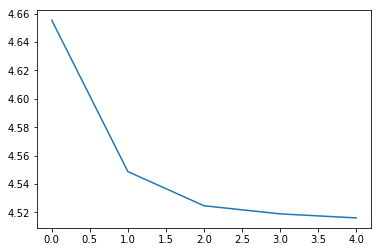

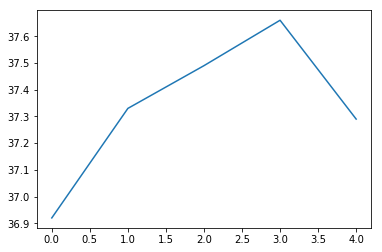

In [218]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(out[0,:])
plt.show()


plt.figure()
plt.plot(val_label[0,:])
plt.show()

